# Civil Structure Fault Classification using Vibration Signals

## Motivation

Thousands of lives are lost due to faults in civil structures each year. Detecting potential faults in large civil structures is key to preventing such mass calamities. Structural health monitoring (SHM) is an important and growing field with widespread application in civil engineering and architecture design. Structural health monitoring (SHM) will play a crucial role in making structures safer by detecting potential failures well before they actual happen.

In this project, we want to create a model that will be able to predict the types of fault in a civil structure.

## Dataset

There are civil structure design benchmarks available for Structural Health Monitoring (SHM) prupose. One such benchmark model was established in the Earth-quake Engineering Research Facility at the University of BritishColumbia (UBC, Canada). The model used is a four-storey with two-bay-by-two-bay steel frame scale structure. The size of each plane is 1.5 m × 1.5 m, the height of each floor is 0.9 m, and each floor has eight braces. The benchmark model is shown in the following figure.


Civil structure layout used for simulation

![Experimental setup](image.png)

Sensor placement setup

![Sensor setup](image1.PNG)

#### Experimental conditions

A 140 data points - dataset is recorded with the help of 16 sensors. Each datapoint represents a vibration signal of length 40000. These signals are categorized in 6 types of fault and a normal class. In total, 7 classes that are used for classification by Machine learning models.

The layout shown above was used to generate data in simulation software. The simulation software used for generating the data is **DataGen2e**. The software has a set of libraries and civil benchmark structures. After selecting the structure layout, we need to create conditions under which we want to create the data. The data for this project is collected with the following conditions.

1. Undamaged case
2. All braces of 1st story are broken
3. all braces of 1st and 3rd story are broken
4. 1 brace on 1st story is broken
5. 1 brace on 3rd story is broken
6. condition 5 + unscrew the element 18
7. Area of brace 1 is reduced to 2/3rd of story 1

After selecting the conditions, the structure is then excited using twice the natural frequency for 40 seconds under each condition. The vibration signals at each sensor are collected with 1000 Hz frequency. We have collected 20 datapoints for each condition.




## Steps

**1. Data Processing and Visualization**

**2. Feature Engineering**

**3. Machine Learning methods and performace evaluation**

**4. Deep Learning method and performace evaluation**

**5. Conclusion**


**Appendix**

We will import all the required libraries here

In [24]:
# Regular libraries
import numpy as np
import pandas as pd
import scipy.stats
import os

# Graphing libraries
import matplotlib.pyplot as plt
import seaborn as sn

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Warning handling library
import warnings
warnings.filterwarnings('ignore')

## 1. Data Processing and Visualization

Let us now load the data. The data is stored as an array in '.npy' file format. Labels are also stored in the same file format. After loading the data, we will print the shape and visualize the data.

In [25]:
data = np.load('data.npy', allow_pickle = True)
labels = np.load('labels.npy', allow_pickle = True)

In [26]:
print('Number of data points: ',data.shape[0])
print('Number of sensors: ',data.shape[1])
print('Signal length: ',data.shape[2])
print('Classes: ', np.unique(labels))

Number of data points:  140
Number of sensors:  16
Signal length:  40000
Classes:  [0 1 2 3 4 5 6]


The data loaded above is in raw format. We will process the data as per the requirement of models we will be using.

Let us now plot the signal captured by different sensors.

[Text(0, 0.5, 'Amplitude'), Text(0.5, 0, 'Time')]

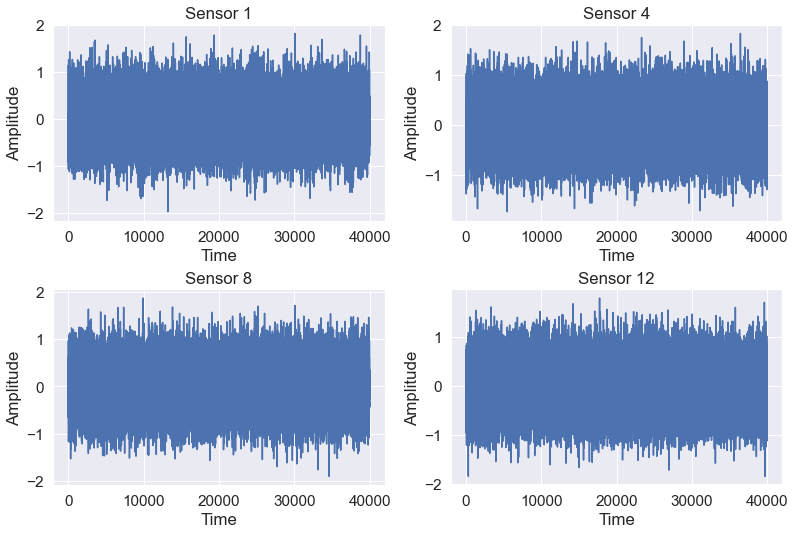

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
fig.subplots_adjust(hspace=.35)
((ax1, ax2), (ax3, ax4)) = axs
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
ax1.plot(data[0, 0, :], label = 'Vibration signal')
ax1.set_title('Sensor 1')
ax1.set(ylabel='Amplitude', xlabel='Time')
ax2.plot(data[0, 4, :], label = 'Vibration signal')
ax2.set_title('Sensor 4')
ax2.set(ylabel='Amplitude', xlabel='Time')
ax3.plot(data[0, 8, :], label = 'Vibration signal')
ax3.set_title('Sensor 8')
ax3.set(ylabel='Amplitude', xlabel='Time')
ax4.plot(data[0, 12, :], label = 'Vibration signal')
ax4.set_title('Sensor 12')
ax4.set(ylabel='Amplitude', xlabel='Time')

These signals are very much alike. Vibration signals are generally normalized before we start feature extraction. The normalization of the signal comes under preprocessing step. There are a few other steps as well that are performed during preprocessing such as noise removal, outlier analysis. For the purpose of this project, we will only normalize the signals.

Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
Normalization can be useful, and even required in some machine learning algorithms when your time series data has input values with differing scales.

There are different normalization techniques such as RMS normalization, mean normalization. Here we will be using Min-Max scaling method.

In [28]:
data = (data - np.min(data, axis = 2, keepdims = True))/(np.max(data, axis = 2, keepdims = True) - \
                                                                    np.min(data, axis = 2, keepdims = True))

### Scaled data after Normalization

[Text(0, 0.5, 'Amplitude'), Text(0.5, 0, 'Time')]

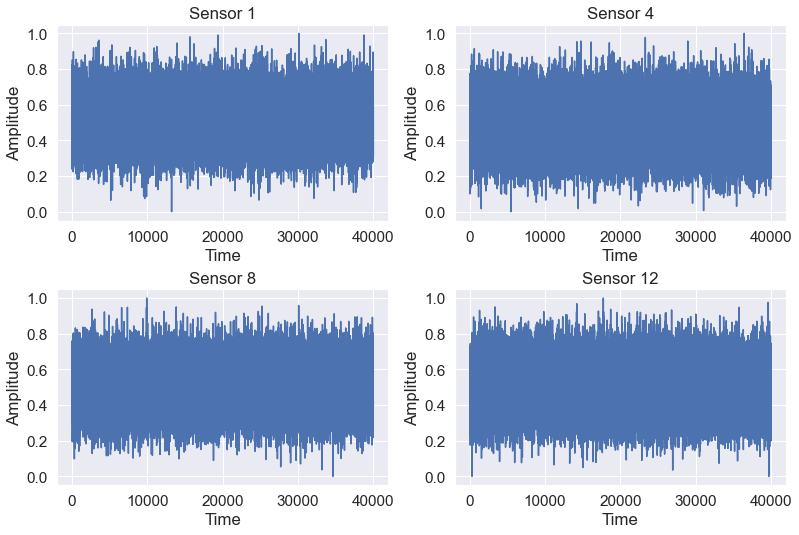

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
fig.subplots_adjust(hspace=.35)
((ax1, ax2), (ax3, ax4)) = axs
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
ax1.plot(data[0, 0, :], label = 'Vibration signal')
ax1.set_title('Sensor 1')
ax1.set(ylabel='Amplitude', xlabel='Time')
ax2.plot(data[0, 4, :], label = 'Vibration signal')
ax2.set_title('Sensor 4')
ax2.set(ylabel='Amplitude', xlabel='Time')
ax3.plot(data[0, 8, :], label = 'Vibration signal')
ax3.set_title('Sensor 8')
ax3.set(ylabel='Amplitude', xlabel='Time')
ax4.plot(data[0, 12, :], label = 'Vibration signal')
ax4.set_title('Sensor 12')
ax4.set(ylabel='Amplitude', xlabel='Time')

Let us save the processed data that we will use to train the models later.

In [30]:
np.save('data_processed.npy', data)
np.save('labels_processed.npy', labels)

## 2. Feature Engineering

To train our machine learning models, we will use Feature Engineering. Before that, let us see what Feature Engineering is.

### What is Feature Engineering?

Feature Engineering is an important step in solving Machine Learning problem. It is a process to extract useful information based on domain knowledge from raw data. The extracted useful information is a set of features that help machine learning algorithm to solve the problem with improved performance. 

A feature is a numeric representation of raw data. There are many ways to extract features from raw data. The right features are relevant to the task at hand and should be easy for the model to ingest. Feature engineering is the process of formulating the most appropriate features given the data, the model, and the task. 

The number of features is also important. If there are not enough informative features, then the model will be unable to perform the ultimate task. If there are too many features, or if most of them are irrelevant, then the model will be more expensive and tricky to train. Something might go awry in the training process that impacts the model’s performance.

### Feature Extraction

After normalizing the signal, we will start extracting features to help shallow Machine Learning Algorithms perform better on this dataset. We will be extracting simple yet powerful statistical features to classify these signals. There are few features that are specific to vibration signal analysis such as Crest factor, Shape factor. At the root, these features are also statistical in nature.

1. mean
2. median
3. min
4. max
5. peak_to_peak
6. variance
7. rms
8. absolute_mean
9. shape_factor
10. impulse_factor
11. crest_factor
12. clearance_factor
13. std
14. skewness
15. kurtosis
16. abslogmean
17. meanabsdev
18. medianabsdev
19. midrange
20. coeff_var

In the appendix, all the features are explained.

The are a few reasons behind extracting these features. These features are easy-to-calculate. Besides, these features captures the signal characteristics good enough in most of the cases. The paper published by W. Caesarendra (attached in Reference section, number 10) discusses the benefits of using these features over using complicated features such as frequency domain features. In some cases, the frequency domain features reveal more information about the underlying nature of the signals. In most of the cases, these features are sufficient.

Following class comprises of 20 features.

In [1]:
class Featurizer():
    
    def __init__(self, data, axis = 1):
        self.data = data
        self.axis = axis
    
    def mean(self):
        ans = np.mean(self.data, self.axis)
        return ans

    def median(self):
        ans = np.median(self.data, self.axis)
        return ans

    def min_value(self):
        ans = np.min(self.data, self.axis)
        return ans

    def max_value(self):
        ans = np.max(self.data, self.axis)
        return ans

    def peak_to_peak(self):
        ans = np.max(self.data, self.axis) - np.min(self.data, self.axis)
        return ans

    def variance(self):
        ans = np.var(self.data, self.axis)
        return ans

    def rms(self):
        ans = np.sqrt(np.mean(self.data ** 2, self.axis))
        return ans

    def abs_mean(self):
        ans = np.mean(np.absolute(self.data), self.axis)
        return ans

    def shapefactor(self):
        ans = self.rms() / self.abs_mean()
        return ans

    def impulsefactor(self):
        ans = np.max(np.absolute(self.data), self.axis) / self.abs_mean()
        return ans

    def crestfactor(self):
        ans = np.max(np.absolute(self.data), self.axis) / np.sqrt(np.mean(self.data ** 2, self.axis))
        return ans

    def clearancefactor(self):
        ans = np.max(np.absolute(self.data), self.axis)
        ans /= ((np.mean(np.sqrt(np.absolute(self.data)), self.axis)) ** 2)
        return ans

    def std(self):
        ans = np.std(self.data, self.axis)
        return ans

    def skew(self):
        ans = scipy.stats.skew(self.data, self.axis)
        return ans

    def kurtosis(self):
        ans = scipy.stats.kurtosis(self.data, self.axis)
        return ans

    def abslogmean(self):
        ans = np.mean(np.log(np.abs(self.data)+1e-12), self.axis)
        return ans

    def meanabsdev(self):
        if self.axis == 0:
            ans = np.mean(np.abs(self.data - np.mean(self.data, self.axis)), self.axis)
        else:
            ans = np.mean(
                np.abs(self.data - np.mean(self.data, self.axis).reshape(self.data.shape[0], 1)), self.axis)
        return ans

    def medianabsdev(self):
        if self.axis == 0:
            ans = np.median(np.abs(self.data - np.median(self.data, self.axis)), self.axis)
        else:
            ans = np.median(
                np.abs(self.data - np.median(self.data, self.axis).reshape(self.data.shape[0], 1)), self.axis)
        return ans

    def midrange(self):
        ans = (np.max(self.data, self.axis) + np.min(self.data, self.axis)) / 2
        return ans

    def coeff_var(self):
        ans = scipy.stats.variation(self.data, self.axis)
        return ans
    
    all_funcs = [mean, median, min_value, max_value, peak_to_peak, variance, \
                rms, abs_mean, shapefactor, impulsefactor,crestfactor, clearancefactor, \
                std, skew, kurtosis, abslogmean, meanabsdev, medianabsdev, midrange, coeff_var]
    
    features = ['mean', 'median', 'min_value', 'max_value', 'peak_to_peak', 'variance', \
                'rms', 'abs_mean', 'shapefactor', 'impulsefactor', 'crestfactor', 'clearancefactor', \
                'std', 'skew', 'kurtosis', 'abslogmean', 'meanabsdev', 'medianabsdev', 'midrange', 'coeff_var']
        

Let us now use the above class to extract the features for our dataset. The class needs to be instantiated with a dataset and axis along which we want to extract features. We will extract features for each sensor's output

Loading the data

In [32]:
data = np.load('data.npy', allow_pickle = True)

In [33]:
num_sensors = 16
featurized_data = []
for sensor in range(num_sensors):
    sensor_feature = []
    f = Featurizer(data[:, sensor, :], axis = 1)
    for func in f.all_funcs:
        sensor_feature.append(func(f))
    featurized_data.append(np.array(sensor_feature).T)
featurized_data = np.array(featurized_data)

In [34]:
print('Shape of the featurized data: ', featurized_data.shape)

Shape of the featurized data:  (16, 140, 20)


Now we will merge the features from all the signals of each datapoint to form a complete feature vector

In [35]:
num_datapoints = featurized_data.shape[1]
final_data = []
for i in range(num_datapoints):
    final_data.append(featurized_data[:, i, :].ravel())
final_data = np.array(final_data)

In [36]:
print('Final shape of the featurized data: ', final_data.shape)

Final shape of the featurized data:  (140, 320)


We have 16 sensors. 20 features are extracted from each sensor's output. As a result we have 20*16 = 320 features per datapoint.

Saving the featurized data

In [37]:
np.save('featurized_data.npy', final_data)

 Now its time to train models and see how our feature extraction works.
 We will load the featurized data.

In [38]:
x_data = np.load('featurized_data.npy', allow_pickle = True)
y_data = np.load('labels.npy', allow_pickle = True)

## 3. Machine Learning methods and performace evaluation

In the modeling part, we will train classical machine learning algorithms on featurized data. For the purpose of this project, we will train the following algorithms.

1. Random Forest
2. Support Vector Classifier
3. Logistic Regression
4. k Nearest Neighbors

Let us train the models directly with default setting. Here we will report the 5 fold accuracy.

Random Forest

In [39]:
rf = RandomForestClassifier()
rf_f_scores = cross_val_score(rf, x_data, y_data, cv=5)
rf_f_acc = np.mean(rf_f_scores)

Support Vector Classifier

In [40]:
svc = SVC()
svc_f_scores = cross_val_score(svc, x_data, y_data, cv=5)
svc_f_acc = np.mean(svc_f_scores)

Logistic Regression

In [41]:
lr = LogisticRegression(solver='liblinear')
lr_f_scores = cross_val_score(lr, x_data, y_data, cv=5)
lr_f_acc = np.mean(lr_f_scores)

k Nearest Neighbors

In [42]:
knn = KNeighborsClassifier()
knn_f_scores = cross_val_score(knn, x_data, y_data, cv=5)
knn_f_acc = np.mean(knn_f_scores)

#### Result on complete dataset

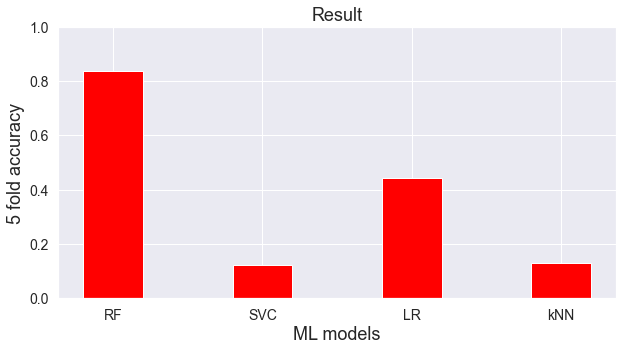

In [43]:
data_r = {'RF':rf_f_acc, 'SVC':svc_f_acc, 'LR':lr_f_acc, 'kNN':knn_f_acc}
algorithm = list(data_r.keys())
accuracy = list(data_r.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(algorithm, accuracy, color ='red', width = 0.4)
plt.xlabel("ML models", fontsize = 18)
plt.ylabel("5 fold accuracy", fontsize = 18)
plt.title("Result", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([0, 1])
plt.show()

The maximum accuracy is achieved by Random Forest. Following are the algorithm wise result.

In [44]:
print('Random Forest Accuracy: ', rf_f_acc*100)
print('Support Vector Classifier Accuracy: ', svc_f_acc*100)
print('Logistic Regression Accuracy: ', lr_f_acc*100)
print('K Nearest Neighbours Accuracy: ', knn_f_acc*100)

Random Forest Accuracy:  83.57142857142857
Support Vector Classifier Accuracy:  12.142857142857144
Logistic Regression Accuracy:  44.28571428571429
K Nearest Neighbours Accuracy:  12.857142857142856


We will analyze the performance of Random Forest algorithm. We will train the algorithm again with a designated test set. We want to check class-wise prediction.

Following cell creates trainset and testset from our complete data

In [45]:
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(7):
    current_class_data = x_data[i*20: i*20 + 20]
    X_train.append(current_class_data[0: 16])
    X_test.append(current_class_data[16: ])
    current_class_labels = y_data[i*20: i*20 + 20]
    y_train.append(current_class_labels[0: 16])
    y_test.append(current_class_labels[16: ])
X_train = np.array(X_train).reshape(-1, 320)
X_test = np.array(X_test).reshape(-1, 320)
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

Lets train the model

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.8571428571428571


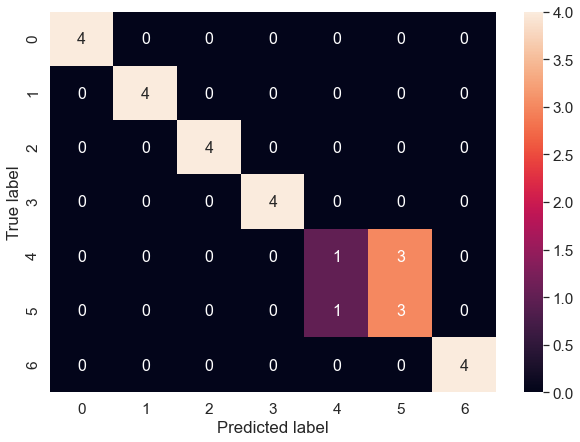

In [47]:
conf_matrix = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456"], columns = [i for i in "0123456"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We initially discussed the conditions under which we collected the data. Here, the indexing starts with zero (Normal condition).

As we can see that the model is mainly getting confused between class 4 and class 5. After looking at the data, we realized that the class 5 fault is same as class 4 with just one bolt loosened. 

class 4: 1 brace on 3rd story is broken

class 5: 1 brace on 3rd story is broken + unscrew the element 18

The signals generated for class 5 and class 4 are very similar. As a result, the features are not distinguishable for these two classes. Hence, our model's performance is affected.

Let us drop the class 4 datapoints and just train on 6 classes to see of our contention is correct.

In [31]:
idx = (y_data != 4)
x_data = x_data[idx]
y_data = np.array([i for i in range(6) for j in range(20)])

Random Forest

In [32]:
rf = RandomForestClassifier()
rf_f_scores = cross_val_score(rf, x_data, y_data, cv=5)
rf_f_acc = np.mean(rf_f_scores)

Support Vector Classifier

In [33]:
svc = SVC()
svc_f_scores = cross_val_score(svc, x_data, y_data, cv=5)
svc_f_acc = np.mean(svc_f_scores)

Logistic Regression

In [34]:
lr = LogisticRegression(solver='liblinear')
lr_f_scores = cross_val_score(lr, x_data, y_data, cv=5)
lr_f_acc = np.mean(lr_f_scores)

k Nearest Neighbors

In [35]:
knn = KNeighborsClassifier()
knn_f_scores = cross_val_score(knn, x_data, y_data, cv=5)
knn_f_acc = np.mean(knn_f_scores)

#### Result on complete dataset

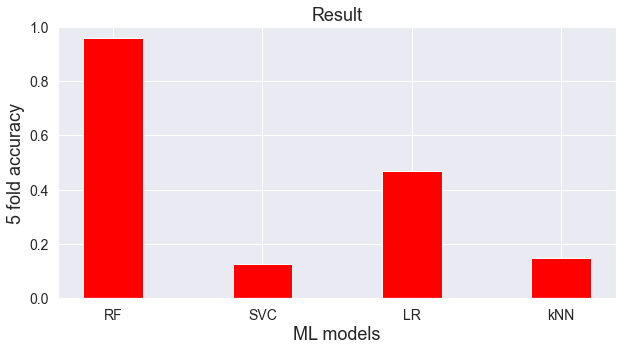

In [36]:
data_r = {'RF':rf_f_acc, 'SVC':svc_f_acc, 'LR':lr_f_acc, 'kNN':knn_f_acc}
algorithm = list(data_r.keys())
accuracy = list(data_r.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(algorithm, accuracy, color ='red', width = 0.4)
plt.xlabel("ML models", fontsize = 18)
plt.ylabel("5 fold accuracy", fontsize = 18)
plt.title("Result", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([0, 1])
plt.show()

In [37]:
print('Random Forest Accuracy: ', rf_f_acc*100)
print('Support Vector Classifier Accuracy: ', svc_f_acc*100)
print('Logistic Regression Accuracy: ', lr_f_acc*100)
print('K Nearest Neighbours Accuracy: ', knn_f_acc*100)

Random Forest Accuracy:  95.83333333333334
Support Vector Classifier Accuracy:  12.5
Logistic Regression Accuracy:  46.666666666666664
K Nearest Neighbours Accuracy:  15.0


As evident from the above figures, the model is able to predict the faults with greater accuracy. The contention proposed previously is verified.

Let us now repeat the previous process to see the class-wise performance

Following cell creates trainset and testset from our data (without class 4)

In [102]:
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(6):
    current_class_data = x_data[i*20: i*20 + 20]
    X_train.append(current_class_data[0: 16])
    X_test.append(current_class_data[16: ])
    current_class_labels = y_data[i*20: i*20 + 20]
    y_train.append(current_class_labels[0: 16])
    y_test.append(current_class_labels[16: ])
X_train = np.array(X_train).reshape(-1, 320)
X_test = np.array(X_test).reshape(-1, 320)
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

Training the best model

In [103]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9166666666666666


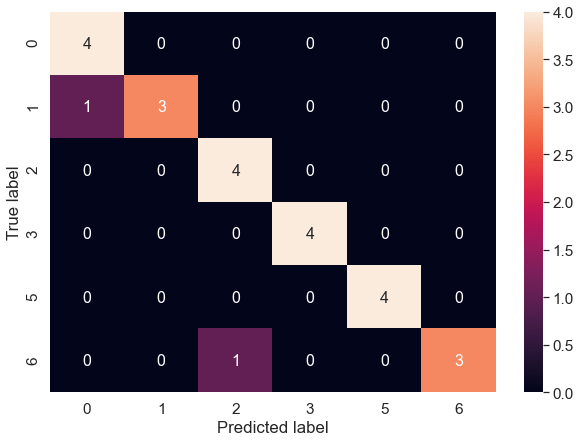

In [104]:
conf_matrix = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012356"], columns = [i for i in "012356"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Machine Learning Method Summary

We trained Machine Learning models with featurized data.

5-fold accuracy for the best model, Random Forest, is 83.57 %.

After analyzing the results, we observed misclassification between class 4 and 5.

5-fold result achieved after dropping class 4 datapoints is 96.66% again on Random Forest model.

## 4. Deep Learning method and performace evaluation

To improve the classification accuracy, we will explore deep learning methods. As our data is 1 dimensional time series data, naturally, we will use 1D Convolutional Neural Network. Previously, we manualy extracted the features from the signal. In deep learning model, the feature extraction is performed by the model itself. We will pass in the processed signal data. As we have 16 different sensors, we will treat each sensor's output as one channel. We will stack these channels and pass them.

The following figures show the overall structure of our 1D CNN model.

![Basic block](figure3.png)

![1D CNN](figure4.png)

![mlp](figure6.png)

Importing deep learning related libraries.

For the purpose of convenience and notebooks length, separate .py files are created for models, training and evaluation. Only the necessary functions are imported.

In [1]:
# Deep learning libraries
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Python files
from model import CNN1D, CNN1D_F
from dataset import Dataset
from train import train, evaluate

Checking if gpu is available

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loading the data

In [4]:
raw_data = np.load('data.npy', allow_pickle = True)
labels = np.load('labels.npy', allow_pickle = True)

In [6]:
print('Data shape: ', raw_data.shape)
print('Number of data points: ', raw_data.shape[0])
print('Number of channels: ', raw_data.shape[1])
print('Signal length: ', raw_data.shape[2])

Data shape:  (140, 16, 40000)
Number of data points:  140
Number of channels:  16
Signal length:  40000


splitting the data in trainset and valset with 4:1 ratio

In [17]:
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(7):
    current_class_data = raw_data[i*20: i*20 + 20]
    current_class_labels = labels[i*20: i*160 + 160]
    idx = np.random.permutation(20)
    current_class_data = current_class_data[idx]
    current_class_labels = current_class_labels[idx]
    train_x.append(current_class_data[0: 16])
    val_x.append(current_class_data[16: ])
    train_y.append(current_class_labels[0: 16])
    val_y.append(current_class_labels[16: ])
train_x = np.array(train_x).reshape(-1, 16, 40000)
val_x = np.array(val_x).reshape(-1, 16, 40000)
train_y = np.array(train_y).reshape(-1)
val_y = np.array(val_y).reshape(-1)

Creating dataloader with a batch size of 32

In [18]:
trainset = Dataset(train_x, train_y)
valset = Dataset(val_x, val_y)
batch_size = 32
train_loader = data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)
val_loader = data.DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)

Instantiating a model with 7 class classification.

As our problem is of classification nature, we will use Cross Entropy loss.

For optimizing model's parameters, Adam optimizer will be used.

To improve the convergence rate, we will use a scheduler with gamma equal to 0.5

We will train the model for 25 epochs

In [19]:
model = CNN1D_F(7).to(device).double()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [5, 10, 15], gamma = 0.5)

In [20]:
num_epochs = 25
loss_train, loss_val, acc_train, acc_val = train(model, num_epochs, criterion, \
                                                        train_loader, val_loader, optimizer, scheduler, True)

Saving model parameters...
Validation accuracy:  14.285714285714285
EPOCH: 0
TRAIN_LOSS: 1.9638838130189864
TRAIN_ACC: 14.285714285714285
VAL_LOSS: 1.9461858923557258
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 1
TRAIN_LOSS: 1.9012948424643663
TRAIN_ACC: 17.857142857142858
VAL_LOSS: 1.946213146105389
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 2
TRAIN_LOSS: 1.8480591340221642
TRAIN_ACC: 38.392857142857146
VAL_LOSS: 1.946277153916899
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 3
TRAIN_LOSS: 1.816218939608643
TRAIN_ACC: 51.78571428571429
VAL_LOSS: 1.9464363653173191
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 4
TRAIN_LOSS: 1.7834386894925625
TRAIN_ACC: 54.46428571428571
VAL_LOSS: 1.9463968166306027
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 5
TRAIN_LOSS: 1.7413742755506512
TRAIN_ACC: 53.57142857142857
VAL_LOSS: 1.9474193770316361
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
EPOCH: 6
TRAIN_LOSS:

Let us check the performance on validation set with the best model and save their outputs for generating the confusion matrix

In [21]:
val_loader = data.DataLoader(dataset = valset, batch_size = 1, shuffle = False)

dir_name = "results/"
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".pth"):
        PATH = os.path.join(dir_name, item)

weights = torch.load(PATH)
model.load_state_dict(weights)

observations = evaluate(model, val_loader)
predictions, y_test = observations[:, 0], observations[:, 1]
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.32142857142857145


Training stats and graphs

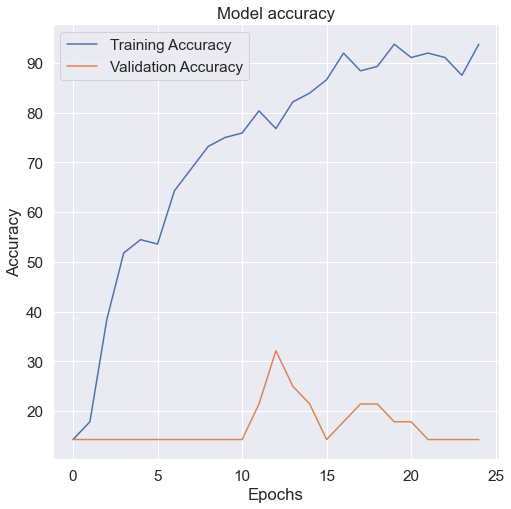

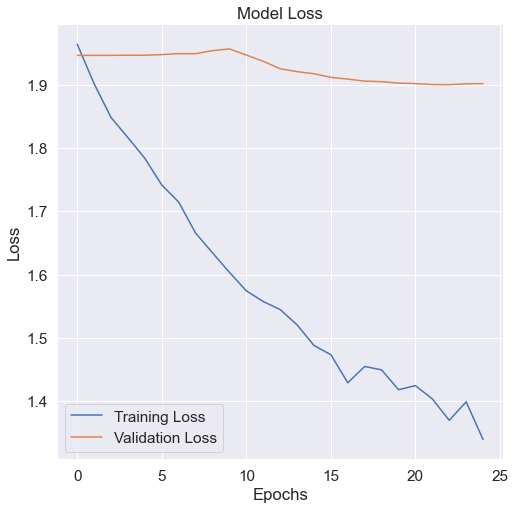

In [48]:
plt.figure(figsize=(8,8))
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.legend()
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('results/accuracy_1120.png')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('results/loss_1120.png')
plt.show()

Confusion matrix

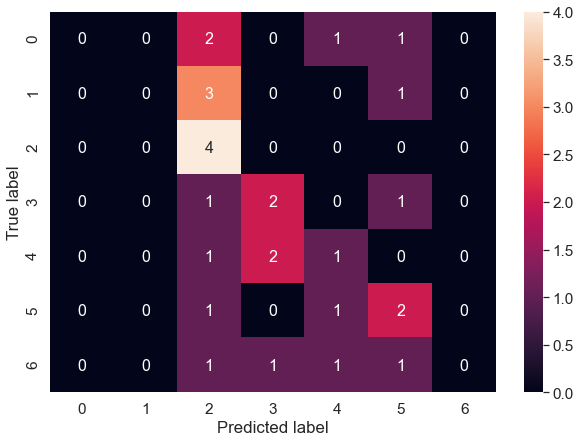

In [23]:
conf_matrix = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456"], columns = [i for i in "0123456"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('results/conf_matrix_1120.png')
plt.show()

Looking at the performance, we can safely conclude that the model is overfitting the training data. This is expected as deep learning models are data hungry. We have only 140 signals. To avoid this, we need to augment the data.

#### Data augmentation

Now, before we proceed with deep learning model training, we will augment the data. Our signal length is 40,000. We can make use of this. We will chop these 40,000 samples long signals into smaller 5,000 samples signals. As a result, from one signal, we will generate 8 signals. Finally, we will have 140 * 8 = 1120 signals

Loading the processed data and performing data augmentation

In [6]:
data = np.load('data_processed.npy', allow_pickle = True)

In [7]:
aug_data = []
for i in range(140):
    current_chunk = data[i]
    for i in range(8):
        aug_data.append(current_chunk[:, i*5000:i*5000 + 5000])

In [8]:
aug_data = np.array(aug_data)

In [9]:
labels = []
for i in range(7):
    for j in range(160):
        labels.append(i)

In [10]:
labels = np.array(labels)

Lets check the final data shape

In [11]:
print('Augmented data shape: ', aug_data.shape)
print('Number of data points: ', aug_data.shape[0])
print('Number of channels: ', aug_data.shape[1])
print('Signal length: ', aug_data.shape[2])

Augmented data shape:  (1120, 16, 5000)
Number of data points:  1120
Number of channels:  16
Signal length:  5000


Saving the augmented data

In [46]:
np.save('data_1120.npy', aug_data)
np.save('labels_1120.npy', labels)

Loading the augmented data

In [67]:
x_data = np.load('data_1120.npy', allow_pickle = True)
y_data = np.load('labels_1120.npy', allow_pickle = True)

splitting the data in trainset and valset with 4:1 ratio

In [68]:
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(7):
    current_class_data = x_data[i*160: i*160 + 160]
    current_class_labels = y_data[i*160: i*160 + 160]
    idx = np.random.permutation(160)
    current_class_data = current_class_data[idx]
    current_class_labels = current_class_labels[idx]
    train_x.append(current_class_data[0: 128])
    val_x.append(current_class_data[128: ])
    train_y.append(current_class_labels[0: 128])
    val_y.append(current_class_labels[128: ])
train_x = np.array(train_x).reshape(-1, 16, 5000)
val_x = np.array(val_x).reshape(-1, 16, 5000)
train_y = np.array(train_y).reshape(-1)
val_y = np.array(val_y).reshape(-1)

Creating dataloader with a batch size of 32

In [69]:
trainset = Dataset(train_x, train_y)
valset = Dataset(val_x, val_y)
batch_size = 32
train_loader = data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)
val_loader = data.DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)

Instantiating a model with 7 class classification.

As our problem is of classification nature, we will use Cross Entropy loss.

For optimizing model's parameters, Adam optimizer will be used.

To improve the convergence rate, we will use a scheduler with gamma equal to 0.5

We will train the model for 25 epochs

In [70]:
model = CNN1D(7).to(device).double()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [5, 10, 15], gamma = 0.5)

In [71]:
num_epochs = 25
loss_train, loss_val, acc_train, acc_val = train(model, num_epochs, criterion, \
                                                        train_loader, val_loader, optimizer, scheduler, True)

Saving model parameters...
Validation accuracy:  14.285714285714285
EPOCH: 0
TRAIN_LOSS: 1.9590199476896797
TRAIN_ACC: 13.727678571428573
VAL_LOSS: 1.9449057967102927
VAL_ACC: 14.285714285714285
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  19.196428571428573
EPOCH: 1
TRAIN_LOSS: 1.5061663222151647
TRAIN_ACC: 35.714285714285715
VAL_LOSS: 3.35406034365203
VAL_ACC: 19.196428571428573
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  54.91071428571429
EPOCH: 2
TRAIN_LOSS: 1.0566340432375683
TRAIN_ACC: 48.549107142857146
VAL_LOSS: 0.9059904854630068
VAL_ACC: 54.91071428571429
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  66.51785714285714
EPOCH: 3
TRAIN_LOSS: 0.7613526331512179
TRAIN_ACC: 63.61607142857143
VAL_LOSS: 0.754616161920149
VAL_ACC: 66.51785714285714
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  69.64285714285714
EPOCH: 4
TRAIN_LOSS: 0.5165788347477279
TRAIN_ACC: 75.781

Let us check the performance on validation set with the best model and save their outputs for generating the confusion matrix

In [72]:
val_loader = data.DataLoader(dataset = valset, batch_size = 1, shuffle = False)

dir_name = "results/"
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".pth"):
        PATH = os.path.join(dir_name, item)

weights = torch.load(PATH)
model.load_state_dict(weights)

observations = evaluate(model, val_loader)
predictions, y_test = observations[:, 0], observations[:, 1]
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.8571428571428571


Training stats and graphs

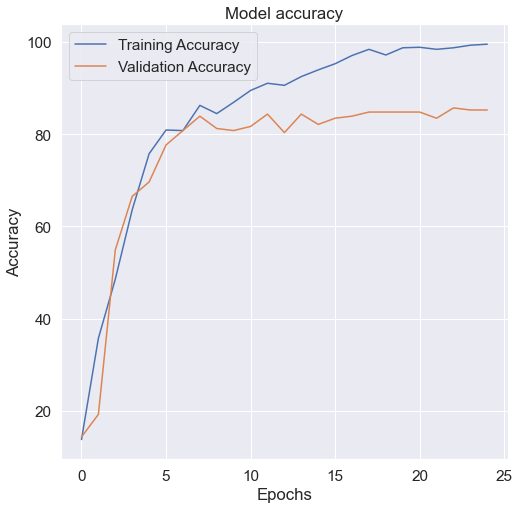

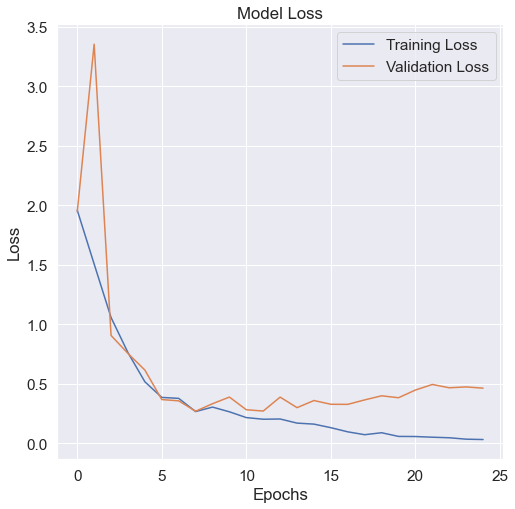

In [73]:
plt.figure(figsize=(8,8))
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.legend()
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('results/accuracy_1120.png')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('results/loss_1120.png')
plt.show()

Confusion matrix

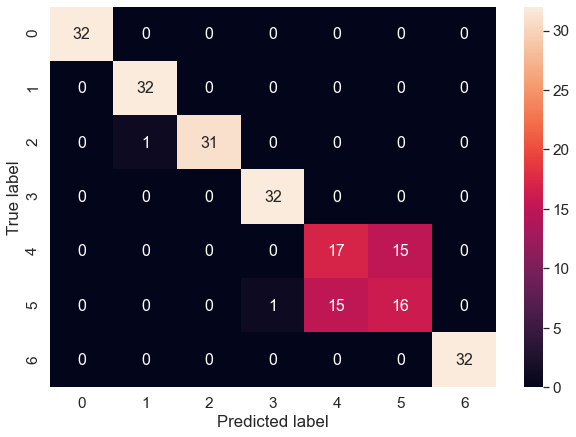

In [74]:
conf_matrix = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "0123456"], columns = [i for i in "0123456"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('results/conf_matrix_1120.png')
plt.show()

Similar to our machine learning model observation, deep learning model also struggles to distinguish between class 4 and class 5. But the deep learning model performs better than Random forest. In this run we achieved 85.71 % accuracy. For deep learning model, we ran the model 5 times with different seeds. The 5-fold accuracy for 1D CNN is 87.19 % which higher than Random Forest's 5-fold accuracy of 83.71%.

Similar to machine learning approach, we will drop the datapoints of class 4 and retrain the model.

Dropping the class 4 and relabeling the data.

In [57]:
idx = (y_data != 4)
x_data = x_data[idx]
y_data = np.array([i for i in range(6) for j in range(160)])

splitting the data in trainset and valset with 4:1 ratio

In [58]:
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(6):
    current_class_data = x_data[i*160: i*160 + 160]
    current_class_labels = y_data[i*160: i*160 + 160]
    idx = np.random.permutation(160)
    current_class_data = current_class_data[idx]
    current_class_labels = current_class_labels[idx]
    train_x.append(current_class_data[0: 128])
    val_x.append(current_class_data[128: ])
    train_y.append(current_class_labels[0: 128])
    val_y.append(current_class_labels[128: ])
train_x = np.array(train_x).reshape(-1, 16, 5000)
val_x = np.array(val_x).reshape(-1, 16, 5000)
train_y = np.array(train_y).reshape(-1)
val_y = np.array(val_y).reshape(-1)

Creating dataloader with a batch size of 32

In [59]:
trainset = Dataset(train_x, train_y)
valset = Dataset(val_x, val_y)
batch_size = 32
train_loader = data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)
val_loader = data.DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)

Instantiating a model with 6 class classification instead of 7 classes

Everything else is kept same as previous method

In [62]:
model = CNN1D(6).to(device).double()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [5, 10, 15], gamma = 0.5)

In [63]:
num_epochs = 25
loss_train, loss_val, acc_train, acc_val = train(model, num_epochs, criterion, \
                                                        train_loader, val_loader, optimizer, scheduler, True)

Saving model parameters...
Validation accuracy:  16.145833333333336
EPOCH: 0
TRAIN_LOSS: 1.7120778190124424
TRAIN_ACC: 24.348958333333336
VAL_LOSS: 1.8208114770767274
VAL_ACC: 16.145833333333336
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  17.708333333333336
EPOCH: 1
TRAIN_LOSS: 1.2432448573343677
TRAIN_ACC: 43.75
VAL_LOSS: 2.070298265265168
VAL_ACC: 17.708333333333336
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  64.0625
EPOCH: 2
TRAIN_LOSS: 0.862180467987805
TRAIN_ACC: 60.15625
VAL_LOSS: 0.7999574121586982
VAL_ACC: 64.0625
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  68.22916666666666
EPOCH: 3
TRAIN_LOSS: 0.5317976962973608
TRAIN_ACC: 74.86979166666666
VAL_LOSS: 0.8260267876279621
VAL_ACC: 68.22916666666666
+++++++++++++++++++++++++
Saving model parameters...
Validation accuracy:  70.3125
EPOCH: 4
TRAIN_LOSS: 0.41538525361436696
TRAIN_ACC: 79.94791666666666
VAL_LOSS: 1.0909890414880024
VAL_ACC: 7

Training graphs and confusion matrix

In [64]:
val_loader = data.DataLoader(dataset = valset, batch_size = 1, shuffle = False)

dir_name = "results/"
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".pth"):
        PATH = os.path.join(dir_name, item)

weights = torch.load(PATH)
model.load_state_dict(weights)

observations = evaluate(model, val_loader)
predictions, y_test = observations[:, 0], observations[:, 1]
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9791666666666666


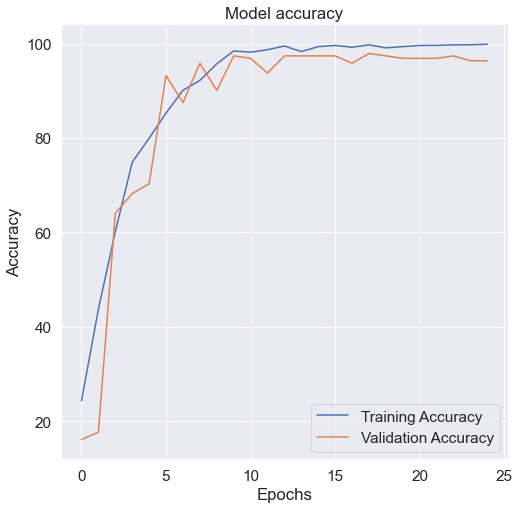

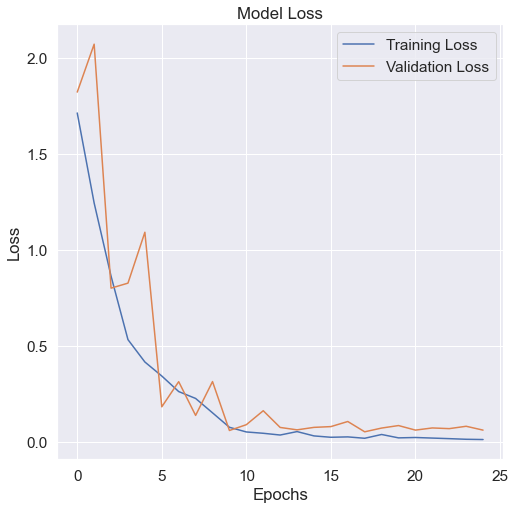

In [65]:
plt.figure(figsize=(8,8))
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.legend()
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('results/accuracy_1120.png')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('results/loss_1120.png')
plt.show()

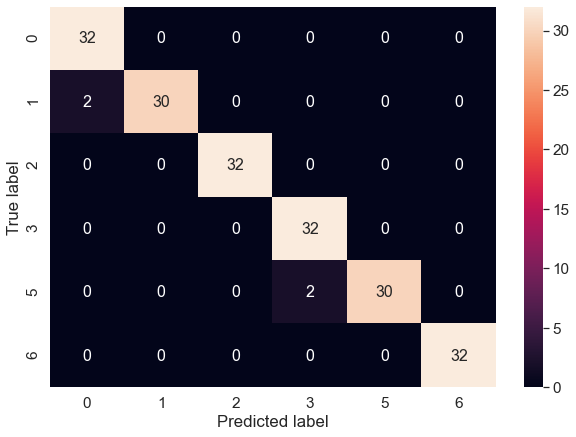

In [66]:
conf_matrix = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012356"], columns = [i for i in "012356"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('results/conf_matrix_1120.png')
plt.show()

There is a substantial improvement in the models performance. Deep learning model achieved ~ 98% accuracy in the current run. The 5-fold accuracy for this setup is 98.21%. The Random Forest model with the same setup achieved 96.66% accuracy.

## 5. Conclusion

In this project, we can detect potential faults and classify them. This shows that AI and Machine Learning can be significantly helpful in the field of Structural health Monitoring and civil engineering applications. With an objective to reduce loss of lives due to faults in civil structures, AI and ML can prove to be a boon for the human civilization.

In this project we used the following concepts that are taught in the course.
1. Data visualization and preprocessing
2. Featurization
3. Machine Learning 
4. Deep Learning
5. Debugging data science

We tried to solve a classification problem. The deep learning model outperforms the standard machine learning models which highly depend on manual feature extraction process.

While analzing the model's performance, we observed that both, ML model and DL model, struggle to classify class 4 and class 5 signals due to their similarity.

We trained the models again without class 4. In this case, the model performance improved. DL model performs better than ML model in this setting as well.

Following is the comparison with 5-fold accuracy.

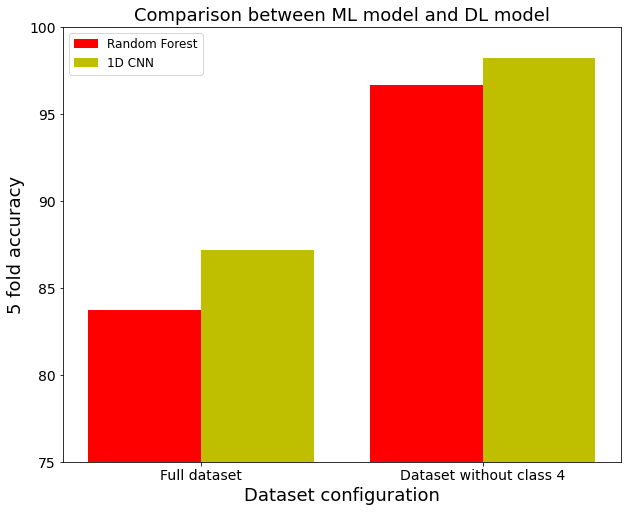

In [3]:
num_bars = np.arange(2)
algorithms = ['Full dataset', 'Dataset without class 4']
fig = plt.figure(figsize = (10, 8))
plt.bar(num_bars - 0.2, [83.71, 96.66], color ='r', width = 0.4, label = 'Random Forest')
plt.bar(num_bars + 0.2, [87.19, 98.21], color ='y', width = 0.4, label = '1D CNN')
plt.legend(fontsize = 12)
plt.xlabel("Dataset configuration", fontsize = 18)
plt.ylabel("5 fold accuracy", fontsize = 18)
plt.title("Comparison between ML model and DL model", fontsize = 18)
plt.xticks([i for i in range(len(algorithms))], algorithms, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([75, 100])
plt.show()

#### Further investigation,related work and References

To improve the model's performance without dropping class 4, we can explore more methods such as frequency domain features for machine learning methods. Another way to approach this problem is to process each sensor's data separately using 1D CNN. This method will be computationally expensive as it requires separate CNN modules to train each signal. These methods can be explored as future work and further investigation apart from discussed here (dropping class 4).

1.The following paper (Magar et al.) makes the interesting use of vibration signals to classify faults in bearings. They have also utilized feature engineering to help the Deep Learning framework make better predictions. 

https://ieeexplore.ieee.org/document/9345676



2.Autodesk is using ML methods to optimize deign in order to make cost reductions and reduce carbon footprint. They go much more in depth and also utilize graph neural networks to make predictions. 

https://www.autodesk.com/research/publications/learning-simulate-design-structural-engineering



3.The following is a very extensive paper that goes much more in depth on the application of Artificial Intelligence (AI) in Civil Engineering. The ideas in this paper can be used to come up with new variants of deep learning models to solve problems more efficiently in civil engineering. 

https://www.researchgate.net/publication/258381956_Artificial_Intelligence_in_Civil_Engineering 



4.This paper gives information about the new advanced data analysis techniques for practical applications of Machine Learning in the field of engineering. To illustrate this research, a seven-step procedure has been discussed to use Machine Learning for Civil Engineering applications. 

https://www.researchgate.net/publication/2770938_Machine_Learning_Techniques_for_Civil_Engineering_Problems



5.The following is aligned with the objective of the project. This paper presents an embedded machine learning approach for Structural Health Monitoring and predicts faults in the sensor reading for better accuracy and reliability of the civil structure.

https://www.researchgate.net/publication/303933051_Machine_learning_techniques_for_structural_health_monitoring



6.The following is a brief overview about the future applications of Artificial Intelligence in field of Engineering and constructions. It points out the current challenges, needs and how AI can transform future engineering and digitalization with its rapid research growth. 

https://www.ips-ai.com/download/readme.pdf



7.The following paper from Kansas University reviews novel Machine Learning Algorithms and their usage in Civil Engineering applications. This article focuses on the data acquisition and validation for better monitoring of Civil Structures.

https://www.tandfonline.com/doi/pdf/10.1080/02630259608970203?casa_token=9U-lfIOWcEcAAAAA:EMhyfdycJ7rRs0e5HBIpb01V8opceuzGTftOlii2U8MGCfaMeEeDcjJlbfZvD9-2ju0Z0M0sGHnQ



8.This book is a very helpful handbook which provides a broad overview of practical as well theoretical aspects are discussed for using Artificial Intelligence and Machine Learning for construction engineering, marine engineering, geotechnical engineering, etc. It addresses many complex civil engineering problems such as drought forecasting, evaporation modeling, and ground water level forecasting.

https://www.routledge.com/A-Primer-on-Machine-Learning-Applications-in-Civil-Engineering/Deka/p/book/9781138323391



9.Book: Feature engineering for machine learning : principles and techniques for data scientists, Zheng, Alice, author.; Casari, Amanda, author. 2018

https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/?ar



10.Research paper: W. Caesarendra and T. Tjahjowidodo, "A review of feature extraction methods in vibration-based condition monitoring and its application for degradation trend estimation of low-speed slew bearing", Machines, vol. 5, no. 4, pp. 21, Sep. 2017.

https://www.mdpi.com/2075-1702/5/4/21

## Appendix

**Mean**: The statistical mean is an arithmetic mean process, in that it adds up all numbers in a data set, and then divides the total by the number of data points.

**Median**: To find the median, the observations are arranged in order from smallest to largest value. If there is an odd number of observations, the median is the middle value. If there is an even number of observations, the median is the average of the two middle values.

**Min_value**: the minimum number in a set of numbers

**Max_value**: the maximum number in a set of numbers

**peak_to_peak**: the difference between the maximun and minimum numbers in a set of numbers

**variance**: Variance describes how much a random variable differs from its expected value.The variance is defined as the average of the squares of the differences between the individual (observed) and the expected value. That means it is always positive. In practice, it is a measure of how much something changes.

**rms**: The RMS value of a set of values is the square root of the arithmetic mean of the squares of the values, or the square of the function that defines the continuous waveform. In the case of the RMS statistic of a random process, the expected value is used instead of the mean.

**abs_mean**: The abs_mean value of a set of values is the arithmetic mean of all the absolute values in a given set of numbers.

**shapefactor**: Shape factor refers to a value that is affected by an object's shape but is independent of its dimensions. It is a ratio of RMS value to the absolute mean of a given set of numbers.

**impulsefactor**: Impulse factor refers to a value that is affected by an absolute maximum values. It is a ratio of maximum of absolute values to the absolute mean of a given set of numbers.

**crestfactor**: Crest factor refers to a value that is affected by an absolute maximum values. It is a ratio of maximum of absolute values to the RMS value of a given set of numbers. Crest factor indicates how extreme the peaks are in a wave. Crest factor 1 indicates no peaks.

**clearancefactor**: Clearance factor is peak value divided by the squared mean value of the square roots of the absolute amplitudes.

**std**: In statistics, the standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean of the set, while a high standard deviation indicates that the values are spread out over a wider range.

**skew**: In statistics, skewness is a measure of the asymmetry of the distribution of a real-valued observations about its mean. The skewness value can be positive, zero, negative, or undefined.

**kurtosis**: Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values.

**abslogmean**: abslogmean is a statistical measure which stands for absolute logarithmic mean of a series of observations. Its takes a mod of each value followed by log and then a mean of the resultant log values

**meanabsdev**: meanabsdev is a statistical measure which stands for mean absolute deviation of a series of observations. The average absolute deviation, or mean absolute deviation (MAD), of a data set is the average of the absolute deviations from a central point. It is a summary statistic of statistical dispersion or variability.

**medianabsdev**: medianabsdev is a statistical measure which stands for median absolute deviation of a series of observations. The median absolute deviation of a data set is the meadian of the absolute deviations from a central point. It is a summary statistic of statistical dispersion or variability.

**midrange**: In statistics, the mid-range or mid-extreme of a set of statistical data values is the arithmetic mean of the maximum and minimum values in a data set.

**coeff_var**: coeff_var stands for coefficient of variation. In statistics, the coefficient of variation (CV), also known as relative standard deviation (RSD), is a standardized measure of dispersion of a distribution. It is often expressed as a percentage, and is defined as the ratio of the standard deviation to the mean.